In [3]:
data_root = "/mnt/local4T/pengfei/projects/PointHuman/PointHuman-ICON/data/thuman2_36views"
scan_data_root = "/mnt/local4T/pengfei/projects/PointHuman/PointHuman-ICON/data/thuman2"
scan_id = "0001"
rotation = "000"
W, H = 512, 512


intrinsic: [[ 0.03038487  0.          0.          0.        ]
 [ 0.         -0.03038487  0.          0.        ]
 [ 0.          0.          0.03038487  0.        ]
 [ 0.          0.          0.          1.        ]]
extrinsic: [[ 0.93969262  0.         -0.34202014 -0.09518682]
 [ 0.          1.          0.          4.7314045 ]
 [ 0.34202014  0.          0.93969262 -0.1246143 ]
 [ 0.          0.          0.          1.        ]]


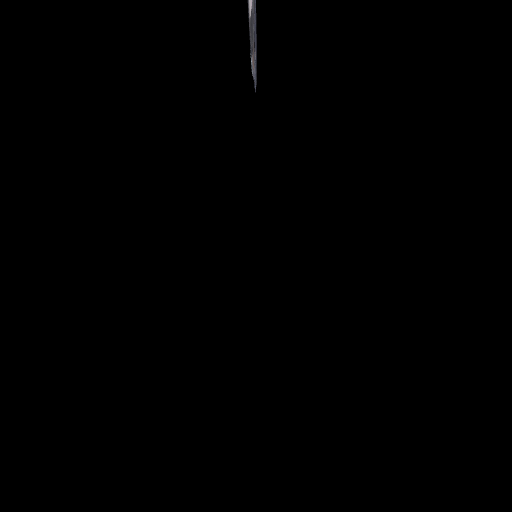

In [4]:
# Use pyrender to test intrinsics and extrinsics matrix.
import pyrender 
import trimesh
import numpy as np
import os.path as osp
import os
from PIL import Image
os.environ['PYOPENGL_PLATFORM'] = 'egl'

# Load camera matrix.
calib = osp.join(data_root, f"{scan_id}/calib/{rotation}.txt")
calib = np.loadtxt(calib)
extrinsic = calib[0:4]
intrinsic = calib[4:]
# scan_scale = intrinsic[0, 0] / np.sqrt(3)
# extrinsic[:3, :4] *= scan_scale

print("intrinsic:", intrinsic)
print("extrinsic:", extrinsic)

# Load scan.
scan = osp.join(scan_data_root, f"scans/{scan_id}/{scan_id}.obj")
mesh = trimesh.load_mesh(scan)
xyzs = mesh.vertices
xyzs = np.concatenate([xyzs, np.ones_like(xyzs[..., :1])], axis=-1)
xyzs = xyzs @ extrinsic.T
mesh.vertices = xyzs[..., :3]
pyrender_mesh = pyrender.Mesh.from_trimesh(mesh)

renderer = pyrender.OffscreenRenderer(viewport_width=W, viewport_height=H)
scene = pyrender.Scene(
    ambient_light=np.array([1.0, 1.0, 1.0, 1.0]),
    bg_color=np.array([0.0, 0.0, 0.0, 0.0]))
# scene.add(pyrender_mesh, pose=extrinsic)
scene.add(pyrender_mesh)

focal = np.sqrt(3)
camera = pyrender.IntrinsicsCamera(
    fx=intrinsic[0, 0] * W / 2.,
    fy=-intrinsic[1, 1] * H / 2.,
    # fx=focal * W / 2.,
    # fy=focal * H / 2.,
    cx=W / 2.,
    cy=H / 2.,
    znear=0.1,
    zfar=100,
)
camera_pose = np.eye(4)
# camera_pose[:3, 3] = [0, 0, 2.0]
scene.add(camera, pose=camera_pose)
# scene.add(camera, pose=extrinsic)
color, depth = renderer.render(scene)

renderer.delete()

Image.fromarray(color)


In [6]:
color.max()


178

In [5]:
depth = osp.join(data_root, scan_id, "depth_F", f"{rotation}.npy")
depth = np.load(depth, allow_pickle=True).item()

d = depth["depth"]
print(np.min(d), np.max(d), np.mean(d))


x = np.linspace(0, 1., W)
y = np.linspace(0, 1., H)
x, y = np.meshgrid(x, y, indexing='xy')
xy = (np.stack([x, y], axis=-1) - 0.5) * 2.
xy = xy[depth["mask"]]

calib = intrinsic @ extrinsic

xyz = np.concatenate([xy, depth["depth"][..., None]], axis=-1)
xyz[..., :2] *= xyz[..., 2:]
xyz[..., 2] = -xyz[..., 2]
xyz = np.concatenate([xyz, np.ones_like(xyz[..., :1])], axis=-1)

xyz = xyz @ np.linalg.inv(calib).T

# xyz = xyz @ np.linalg.inv(extrinsic).T
# xyz = xyz[..., :3]
pcl = trimesh.Trimesh(vertices=xyz)
pcl.export(f"{scan_id}_{rotation}.obj")





0.8067253 1.024989 0.89147264


'# https://github.com/mikedh/trimesh\nv 0.00231540 0.23801203 0.01692547 1.00000000\nv 0.00354111 0.23801328 0.01647510 1.00000000\nv 0.00467829 0.23809463 0.01578306 1.00000000\nv 0.00577435 0.23821396 0.01497614 1.00000000\nv 0.00634428 0.23881399 0.01271726 1.00000000\nv 0.01131095 0.23991710 0.00713812 1.00000000\nv 0.01250445 0.23995611 0.00657033 1.00000000\nv 0.01366334 0.24002789 0.00590312 1.00000000\nv -0.00408202 0.23910573 0.01101243 1.00000000\nv -0.00202733 0.23838100 0.01275376 1.00000000\nv 0.00070115 0.23705086 0.01632922 1.00000000\nv 0.00356840 0.23558644 0.02031536 1.00000000\nv 0.00459303 0.23576373 0.01933350 1.00000000\nv 0.00565233 0.23591117 0.01844152 1.00000000\nv 0.00674542 0.23602922 0.01763823 1.00000000\nv 0.00783740 0.23614921 0.01682868 1.00000000\nv 0.00901478 0.23619231 0.01625210 1.00000000\nv 0.01036145 0.23608088 0.01614469 1.00000000\nv 0.01155970 0.23610488 0.01562610 1.00000000\nv 0.01275749 0.23612950 0.01510559 1.00000000\nv 0.01446930 0.23567

: 